## AudioVision - DistinctVoice training data generation
*Process:* mono speech wav audio recording is convolved with different impulse responses to generate variants. Variants are then mixed with randome background noises and with other mono speech wav recodings. Base signal remains most dominant in final audio signal.

In [6]:
import matplotlib.pyplot as plt
import IPython.display as ipd
from scipy.fftpack import fft
from scipy.io import wavfile
from scipy import signal
import numpy as np
import os

#### Original Audio:

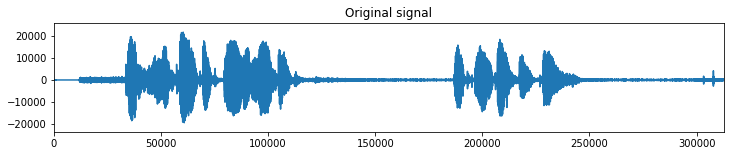

In [7]:
#Extract Raw Audio from Wav File
audio_file_name = "demo.wav"
fs, sig = wavfile.read(audio_file_name)
plt.figure(figsize=(12, 2))
plt.plot(sig)
plt.title('Original signal')
plt.margins(0, 0.1)

In [8]:
## Play original audio
ipd.Audio(audio_file_name)

#### Impulse Response:

In [9]:
# Impulse response in imp_resp directory
fs_imp, imp = wavfile.read('imp_resp/imp_resp_1.wav')

# Zero padding on impulse reponse
imp = np.pad(imp,(0, (sig.size-imp.size)), 'constant')

# Time scale definition 
time=np.linspace(0, len(sig)/fs, num=len(sig))

# Play impulse response
ipd.Audio('imp_resp/imp_resp_1.wav')

### 1. Variant Genearation

In [10]:
# Function definition to compute convolution
def conv(signal, imp_resp):
    ## Convolution
    sig_fft = np.fft.fft(signal)
    imp_fft = np.fft.fft(imp_resp)
    convolved_signal = np.fft.ifft(sig_fft*imp_fft).real
    ## Normalization
    convolved_signal = convolved_signal/max(convolved_signal)
    return convolved_signal

# Normalized convolution of original signal and impulse reponse
conv_sig = conv(sig,imp)

# Original signal ans impulse response normalization
sig = sig/max(sig)
imp = imp/max(imp)

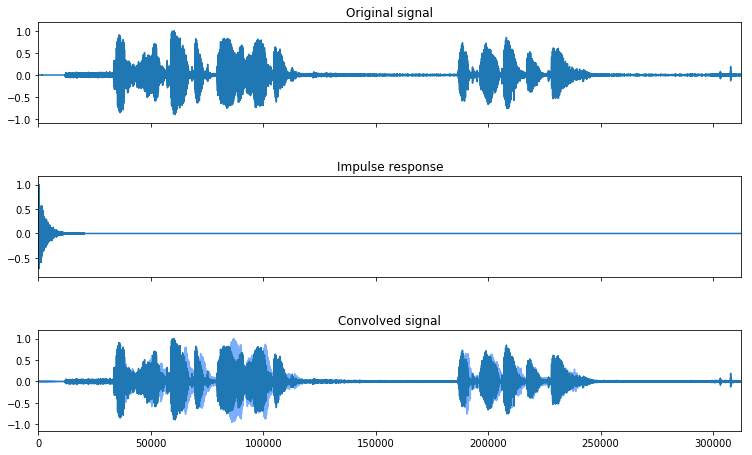

In [11]:
# Figure combined
fig, (ax_orig, ax_imp, ax_conv) = plt.subplots(3, 1, sharex=True)
ax_orig.plot(sig)
ax_orig.set_title('Original signal')
ax_orig.margins(0, 0.1)

ax_imp.plot(imp)
ax_imp.set_title('Impulse response')
ax_imp.margins(0, 0.1)

ax_conv.plot(conv_sig,color = '#7caeff')
ax_conv.plot(sig)
ax_conv.set_title('Convolved signal')
ax_conv.margins(0, 0.1)

fig.tight_layout()
fig.set_size_inches(11, 7)

#### 1.1 All Audio Variant Genearation

In [18]:
# Make directory that will contain all variant audio
train_path = "audio_variant"
if not os.path.exists(train_path):
    try:  
        os.mkdir(train_path)
    except OSError:  
        print ("Creation of the directory %s failed" % train_path)
    else:  
        print ("Successfully created the directory %s " % train_path)

for file in os.listdir("imp_resp"):
    # Impulse response reading, padding and normalization
    fs_imp, imp = wavfile.read("imp_resp/"+file)
    imp = np.pad(imp,(0, (sig.size-imp.size)), 'constant')
    imp = imp/max(imp)
    
    # Wav audio variant generation
    conv_sig = np.asarray(conv(sig,imp), dtype=np.float32)
    variant_file_name = "./audio_variant/variant-"+audio_file_name[:-4]+"-"+file
    wavfile.write(variant_file_name, fs, conv_sig)

#### 1.2 Audio Variant Example

In [19]:
# Play first variant computed
ipd.Audio("./audio_variant/variant-"+audio_file_name[:-4]+"-imp_resp_0.wav")

#### 1. 3 Other Audio Variant Exemple

In [14]:
# Play forth variant computed
ipd.Audio("./audio_variant/variant-"+audio_file_name[:-4]+"-imp_resp_1.wav")

ValueError: could not convert string to float: './audio_variant/variant-demo-imp_resp_4.wav'

### 2. Spectrogram Computation

In [ ]:
# Function definition to compute spectrogram
def log_specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, _, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    fmin = 80 # Hz
    fmax = 8000 # Hz
    freq_slice = np.where((freqs >= fmin) & (freqs <= fmax))
    freqs   = freqs[freq_slice]
    spec = spec[freq_slice,:][0]
    return freqs, np.log(spec.T.astype(np.float32) + eps)

In [ ]:
# Make directory that will contain all training spectrograms
train_path = "train_data"
if not os.path.exists(train_path):
    try:  
        os.mkdir(train_path)
    except OSError:  
        print ("Creation of the directory %s failed" % train_path)
    else:  
        print ("Successfully created the directory %s " % train_path)

#### 2.1 Original Audio Spectrograms _( bin = 1 sec )_

In [ ]:
# Compute original training spectograms
bin_nbr = int(sig.size/fs)

for i in range(bin_nbr):
    
    seg_start = i*fs
    seg_end = (1+i)*fs
    data = sig[seg_start:seg_end]
    _, spectrogram = log_specgram(data, fs)
    
    fig = plt.figure()
    plt.imshow(spectrogram.T, aspect='auto', origin='lower')
    plt.axis('off')
    filename = train_path+'/spectrogam-'+str(i)+'.jpg'
    fig.set_size_inches(4, 4)
    fig.savefig(filename, bbox_inches="tight",pad_inches=-0.3)

#### 2.2 Varaint Audio Spectrograms _( bin = 1 sec )_

In [ ]:
# Compute all variant training spectrograms
for file in os.listdir("audio_variant"):
    fs, sig = wavfile.read("./audio_variant/"+file)
    bin_nbr = int(sig.size/fs)
    for i in range(bin_nbr):
        seg_start = i*fs
        seg_end = (1+i)*fs

        data = sig[seg_start:seg_end]

        _, spectrogram = log_specgram(data, fs)

        fig = plt.figure()
        plt.imshow(spectrogram.T, aspect='auto', origin='lower')
        plt.axis('off')
        filename = train_path+'/spectrogam-'+file[:-4]+'-'+str(i)+'.jpg'
        fig.set_size_inches(4, 4)
        fig.savefig(filename, bbox_inches="tight",pad_inches=-0.3)